In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 한글폰트 설정 (실행 후 런타임 다시 시작하고 다시 실행하면 한글폰트 적용 가능) -> colab 기준, jupyter 사용시 문의바람
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
total_df = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/W_total.csv')
total_df.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN


In [ ]:
# 차 이름 - 모델 매칭 테이블 불러오기
name = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/all_cars(modified).csv')
name.head()

,Unnamed: 0,name,model,maker,prefix,postfix,kind
0,0,렉스턴,렉스턴,쌍용,0,0,['Mid-Large suv']
1,1,K7,K7,기아,0,0,['Sedan']
2,2,투싼,투싼,현대,0,0,['Mid-Large suv']
3,3,기아 4세대 카니발 KA4,카니발,기아,0,0,['van']
4,4,QM6,QM6,르노삼성,0,0,['Mid-Large suv']


In [ ]:
# 차 이름 - 모델 매칭 테이블과 조인
total_df = total_df.merge(name[['name', 'model', 'maker']], left_on = 'car', right_on = 'name', how = 'left')
total_df.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성


In [ ]:
# 상품번호 - 상품명 매칭 테이블 가져오기 및 조인
product = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/product.csv')
product = product.rename(columns = {'name' : 'product_name'})
total_df_item = total_df.copy()
for i in range(1, 7):
  total_df_item = total_df_item.merge(product[['product', 'product_name']], left_on = 'product_%d'%i, right_on = 'product', how = 'left')
  total_df_item = total_df_item.rename(columns = {'product_name' : 'product_%d_name' % i})
  total_df_item = total_df_item.drop(columns = ['product'])
total_df_item.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker,product_1_name,product_2_name,product_3_name,product_4_name,product_5_name,product_6_name
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아,Star,Star,NaN,Star,Star,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대,Super,Super,Super,Super,Super,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아,Star,Star,NaN,Star,Star,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성,Super,Super,NaN,Super,Super,NaN


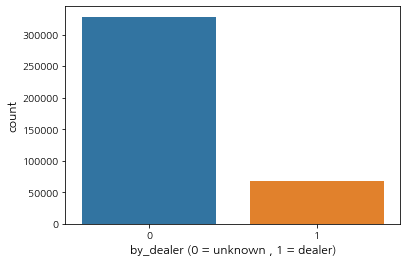

In [ ]:
import seaborn as sns

# 328315 vs 67574 (전체 수 파악)

total_df_item['by_dealer'] = total_df_item['by_dealer'].astype(str)
dealer_count = total_df_item['by_dealer'].value_counts()
sns.barplot(x = dealer_count.index, y = dealer_count)

plt.xlabel('by_dealer (0 = unknown , 1 = dealer)', size = 12)
plt.ylabel('count', size = 12)
plt.show()

모든 구매기록이 by_dealer = 0 으로 되어있는 스토어는 제외하고 분석

In [ ]:
store = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/store_classification.csv')

total_df_item['by_dealer']= total_df_item['by_dealer'].apply(int)
store_dealer = total_df_item.groupby('store')['by_dealer'].sum().sort_values(ascending = False).to_frame()
store = store.merge(store_dealer, on = 'store', how = 'left')

store['dealer_ratio'] = 100 * store['by_dealer'] / store['works']
valid_store = store.loc[store['dealer_ratio'] > 0, 'store']
valid_store

6       8675a9e3aa092a8e0c494aa6d1ed2111
9       a79014bb91cb4466d09c2944987ff430
10      bed571516c31082517e6760a1278e6d3
17      2b114dd67355175ef61b028fa1072cd5
21      89caceedf2d4e04fbd24b99e6ed919ec
                      ...               
1003    1276340fa769c907a73d39e226a3d5d9
1016    bcf9b945351bcf8178ff80345e439844
1022    3e516582f6c88f2b482be3987f5c8a31
1105    1c63ac1c85446f394ff95171b3352c03
1145    70b9851a499fe76de792ddd4a88b612c
Name: store, Length: 234, dtype: object

In [ ]:
total_df_item = total_df_item.loc[total_df_item['store'].isin(valid_store)]
total_df_item['by_dealer'] = total_df_item['by_dealer'].apply(str)
total_df_item.shape

(217087, 23)

In [ ]:
## 브랜드 별 딜러 차이 파악

# 딜러 유무에 따라 데이터프레임 나누는 과정
no_dealer = total_df_item.loc[total_df_item['by_dealer'] == '0']
yes_dealer = total_df_item.loc[total_df_item['by_dealer'] == '1']

# 딜러 유무에 따라 각 브랜드의 차지 비율을 계산
no_top_brand = no_dealer.loc[no_dealer['maker'] != '0','maker'].value_counts().head(15) / (no_dealer.loc[no_dealer['maker'] != '0','maker'].shape[0] / 100) # 이상치 제거
no_top_brand = pd.DataFrame(no_top_brand)
no_top_brand = no_top_brand.rename(columns = {'maker' : 'dealer = 0'})
yes_top_brand = yes_dealer['maker'].value_counts().head(15) / (yes_dealer.shape[0] / 100)
yes_top_brand = pd.DataFrame(yes_top_brand)
yes_top_brand = yes_top_brand.rename(columns = {'maker' : 'dealer = 1'})

dealer_result_b = pd.concat([no_top_brand, yes_top_brand], axis = 1)
dealer_result_b = dealer_result_b.dropna()
dealer_result_b

,dealer = 0,dealer = 1
현대,45.027993,46.622961
기아,29.786847,33.045254
르노삼성,5.309275,7.514725
쌍용,4.754806,3.385918
쉐보레/한국GM,3.853626,3.914227
벤츠,2.711636,1.379229
BMW,1.533221,0.591944
제네시스,1.256661,1.611567
아우디,0.629342,0.137627
혼다,0.584148,0.097671


In [ ]:
## 차종 별 딜러 차이 파악

no_top_model = no_dealer['model'].value_counts().head(15) / (no_dealer.shape[0] / 100)
no_top_model = pd.DataFrame(no_top_model)
no_top_model = no_top_model.rename(columns = {'model' : 'dealer = 0'})
yes_top_model = yes_dealer['model'].value_counts().head(15) / (yes_dealer.shape[0] / 100)
yes_top_model = pd.DataFrame(yes_top_model)
yes_top_model = yes_top_model.rename(columns = {'model' : 'dealer = 1'})

dealer_result_m = pd.concat([no_top_model, yes_top_model], axis = 1)
dealer_result_m = dealer_result_m.dropna()
dealer_result_m

,dealer = 0,dealer = 1
그랜저,10.454609,10.817770
싼타페,7.414740,5.700417
제네시스,5.863035,5.126232
쏘렌토,5.034345,5.428123
쏘나타,4.426371,5.006363
아반떼,4.386241,5.395566
카니발,4.090614,3.311925
K5,3.430471,4.682274
K7,3.415756,3.813597
팰리세이드,2.829854,4.259035


In [ ]:
## 딜러 유무에 따라 각 아이템 별로 차지하는 비율 살피기

# 상대적으로 많이 팔린 아이템 목록
best_item = ['Latitude', 'Artisan', 'Vertex 700', 'Vertex 900', 'Star', 'Super', 'Vertex 500', 'Bisanti', 'TNT', 'Pinnacle', 'Pro']

# 아이템 위치 설정 (1 ~ 6)
i = 1

# 딜러 유무에 따라 각 아이템이 차지하는 비율 산출
no_count = no_dealer['product_%d_name'%i].value_counts()
yes_count = yes_dealer['product_%d_name'%i].value_counts()
no_top_item_1 = no_count.loc[no_count.index.isin(best_item)] / (no_dealer['product_%d_name'%i].dropna().shape[0] / 100)
no_top_item_1 = pd.DataFrame(no_top_item_1)
no_top_item_1 = no_top_item_1.rename(columns = {'product_%d_name'%i : 'dealer = 0'})
yes_top_item_1 = yes_count.loc[yes_count.index.isin(best_item)] / (yes_dealer['product_%d_name'%i].dropna().shape[0] / 100)
yes_top_item_1 = pd.DataFrame(yes_top_item_1)
yes_top_item_1 = yes_top_item_1.rename(columns = {'product_%d_name'%i : 'dealer = 1'})

dealer_result_1 = pd.concat([no_top_item_1, yes_top_item_1], axis = 1)
dealer_result_1 = dealer_result_1.dropna()
dealer_result_1

,dealer = 0,dealer = 1
Artisan,29.675012,24.546423
Latitude,10.915439,9.229881
Star,9.866032,3.411075
Super,9.121615,32.582058
Vertex 700,7.188004,6.117738
Vertex 900,3.334827,2.082162
Vertex 500,2.889381,4.034096
TNT,1.880104,5.244621
Pro,1.637985,0.713292
Pinnacle,0.924334,0.269334


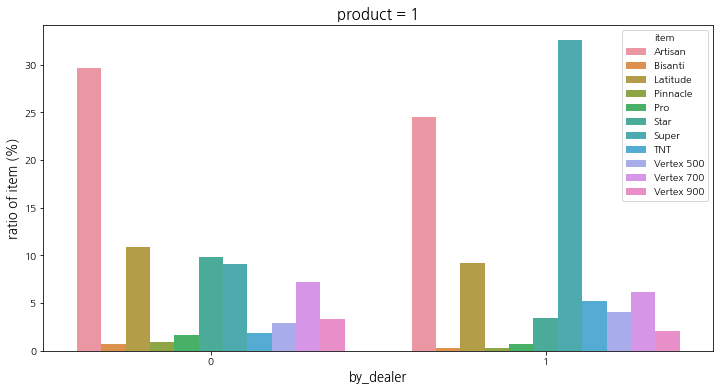

In [ ]:
## 딜러 유무에 따라 각 아이템의 차지 비율 시각화

# 아이템 위치 설정 (1 ~ 6)
i = 1

# 아이템 비율 전처리 (앞 코드와 동일)

no_count = no_dealer['product_%d_name'%i].value_counts()
yes_count = yes_dealer['product_%d_name'%i].value_counts()
no_top_item_1 = no_count.loc[no_count.index.isin(best_item)] / (no_dealer['product_%d_name'%i].dropna().shape[0] / 100)
no_top_item_1 = pd.DataFrame(no_top_item_1)
no_top_item_1 = no_top_item_1.rename(columns = {'product_%d_name'%i : 'dealer = 0'})
yes_top_item_1 = yes_count.loc[yes_count.index.isin(best_item)] / (yes_dealer['product_%d_name'%i].dropna().shape[0] / 100)
yes_top_item_1 = pd.DataFrame(yes_top_item_1)
yes_top_item_1 = yes_top_item_1.rename(columns = {'product_%d_name'%i : 'dealer = 1'})

# seaborn에서 단번에 시각화가 될 수 있도록 전처리
dealer_result = pd.concat([no_top_item_1, yes_top_item_1], axis = 1)
dealer_result = dealer_result.dropna()

dealer_result = dealer_result.reset_index()
dealer_result = dealer_result.rename(columns = {'index' : 'item'})

item_concat = pd.concat([dealer_result[['item', 'dealer = 0']].rename(columns = {'dealer = 0' : 'ratio'}), dealer_result[['item', 'dealer = 1']].rename(columns = {'dealer = 1' : 'ratio'})])
item_concat = item_concat.reset_index(drop = True)
item_concat['by_dealer'] = pd.Series(['0'] * len(best_item) + ['1'] * len(best_item))

item_concat = item_concat.sort_values(by = 'item')

# 최종 시각화
plt.figure(figsize = (12, 6))
sns.barplot(x = 'by_dealer', y = 'ratio', hue = 'item', data = item_concat)
plt.xlabel('by_dealer', size = 13)
plt.ylabel('ratio of item (%)', size = 13)
plt.title('product = %d' %i, size = 15)
plt.show()

In [ ]:
# 참고 : 위 시각화에서 사용된 데이터프레임
item_concat.head()

,item,ratio,by_dealer
0,Artisan,29.675012,0
11,Artisan,24.546423,1
10,Bisanti,0.729034,0
21,Bisanti,0.295972,1
1,Latitude,10.915439,0


In [ ]:
# 많이 나온 조합을 찾기위해 편의상 nan 값을 0으로 채움

for i in range(1, 7):
  total_df_item['product_%d_name'%i] = total_df_item['product_%d_name'%i].fillna(0)
total_df_item.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker,product_1_name,product_2_name,product_3_name,product_4_name,product_5_name,product_6_name
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아,Star,Star,0,Star,Star,0
7,7,20201231130939,현대 ix 투싼 LM,7fb78048e914e4e869c3873db1214ea5,경기도 수원시 권선구,300000,2,0,NaN,NaN,NaN,NaN,102.0,NaN,현대 ix 투싼 LM,투싼,현대,0,0,0,0,Pinnacle,0
14,14,20201230171857,기아 K5,e6c7e13768aecbd70551ec8c9e1a5b18,경기도 부천시 석천로,520000,1,0,85.0,85.0,NaN,NaN,277.0,NaN,기아 K5,K5,기아,Star,Star,0,0,Star,0
24,24,20201230112100,기아 어반 모닝 JA,e6c7e13768aecbd70551ec8c9e1a5b18,경기도 부천시 석천로,520000,1,0,85.0,85.0,NaN,NaN,277.0,NaN,기아 어반 모닝 JA,모닝,기아,Star,Star,0,0,Star,0
52,52,20201229124359,제네시스 GV80,519974660715c022fd8a1ee32e4331b4,경기도 성남시 수정구,540000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,제네시스 GV80,GV80,제네시스,Star,Star,0,Star,Star,0


In [ ]:
# 1 ~ 6 번 위치에 많이 시공된 조합 top 20

gr = total_df_item.loc[total_df_item['model'] == '그랜저']
gr.groupby(['model', 'product_1_name', 'product_2_name','product_3_name','product_4_name','product_5_name','product_6_name'])['regist_dt'].count().sort_values(ascending = False).head(20)

model  product_1_name  product_2_name  product_3_name  product_4_name  product_5_name  product_6_name
그랜저    Artisan         Artisan         0               Artisan         Artisan         0                 4286
       Super           Super           0               Super           Super           0                 2601
       Latitude        Latitude        0               Latitude        Latitude        0                 1977
       Vertex 700      Vertex 700      0               Vertex 700      Vertex 900      0                 1519
       Artisan         Artisan         0               Artisan         Latitude        0                 1273
       Star            Star            0               Star            Star            0                 1130
       0               0               0               0               Artisan         0                 1012
       Vertex 500      Vertex 500      0               Vertex 500      Vertex 500      0                  578
       TNT        

std : 100623 vs 15389


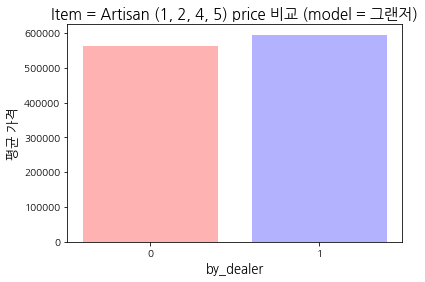

In [ ]:
## 1, 2, 4, 5번 위치가 모두 같은 아이템 종류도 시공된 경우에 대해서 시각화

# 아이템 이름 입력
item = 'Artisan'
model = '그랜저'

# 조건에 맞는 행들만 가져와 가격 정보 추출
all_item = total_df_item.loc[(total_df_item['product_1_name'] == item) & (total_df_item['product_2_name'] == item)  & (total_df_item['product_3_name'] == 0)  & \
                  (total_df_item['product_4_name'] == item)  & (total_df_item['product_5_name'] == item)  & (total_df_item['product_6_name'] == 0) &
                  (total_df_item['model'] == model)]
all_item_0 = all_item.loc[all_item['by_dealer'] == '0', 'price'] # 아래쪽 셀에서 str '0' -> int 0 으로 바꾸는데 이후 실행시 주의 (바로 아래 셀 코드처럼 보완 가능)
all_item_1 = all_item.loc[all_item['by_dealer'] == '1', 'price']

# 최종 시각화
plt.bar(['0', '1'] , [all_item_0.mean(), all_item_1.mean()], color = ['r', 'b'], alpha = 0.3)
plt.title('Item = %s (1, 2, 4, 5) price 비교 (model = %s)' % (item, model), size = 15)
plt.xlabel('by_dealer', size = 13)
plt.ylabel('평균 가격', size = 13)

# 표준편차 출력
print('std : %d vs %d' % (all_item_0.std(), all_item_1.std()))

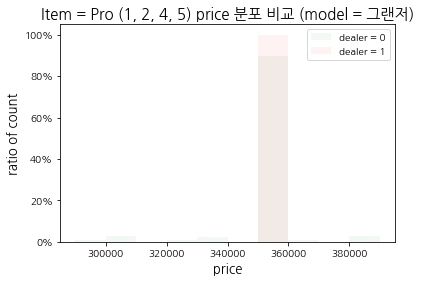

In [ ]:
from matplotlib.ticker import PercentFormatter

## 1, 2, 4, 5번 아이템과 모델명에 대해서 딜러 유무에 따른 가격대 분포 시각화 (기본 조건 : 1, 2, 4, 5번 아이템이 모두 같은 경우)

def Compare_Price(df, model, item):
  all_item = total_df_item.loc[(total_df_item['product_1_name'] == item) & (total_df_item['product_2_name'] == item)  & (total_df_item['product_3_name'] == 0) & 
                  (total_df_item['product_4_name'] == item)  & (total_df_item['product_5_name'] == item)  & (total_df_item['product_6_name'] == 0) &
                  (total_df_item['model'] == model)] # 세부 아이템 조건 조정 가능
  all_item_0 = all_item.loc[(all_item['by_dealer'] == 0) | (all_item['by_dealer'] == '0'), 'price']
  all_item_1 = all_item.loc[(all_item['by_dealer'] == 1) | (all_item['by_dealer'] == '1'), 'price']
  all_item_0 = all_item_0.loc[(all_item_0 <= all_item_0.quantile(0.95)) & (all_item_0 >= all_item_0.quantile(0.05))] # 상, 하위 5%는 제거 (동점 생존)
  all_item_1 = all_item_1.loc[(all_item_1 <= all_item_1.quantile(0.95)) & (all_item_1 >= all_item_1.quantile(0.05))] # (숫자 변경 가능)
  binwidth = 10000
  plt.hist(all_item_0, bins=range(min(all_item_0), max(all_item_0) + binwidth + 1, binwidth), color = 'green', alpha = 0.05, label = 'dealer = 0',\
          weights=np.ones(len(all_item_0)) / len(all_item_0)) # 전체 수 대비 차지하는 비율로 바꿔줌
  plt.hist(all_item_1, bins=range(min(all_item_1), max(all_item_1) + binwidth + 1, binwidth), color = 'red', alpha = 0.05, label = 'dealer = 1',\
        weights=np.ones(len(all_item_1)) / len(all_item_1))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.title('Item = %s (1, 2, 4, 5) price 분포 비교 (model = %s)' % (item, model), size = 15)
  plt.xlabel('price', size = 13)
  plt.ylabel('ratio of count', size = 13)
  plt.legend()
  plt.show()
Compare_Price(total_df_item, '그랜저', 'Pro')

In [ ]:
best_item

['Latitude',
 'Artisan',
 'Vertex 700',
 'Vertex 900',
 'Star',
 'Super',
 'Vertex 500',
 'Bisanti',
 'TNT',
 'Pinnacle',
 'Pro']

In [ ]:
## 각 아이템별 딜러 유무에 따른 가격비를 추출하기 위한 코드

price_ratio = []

for item in best_item: # 많이 팔린 item 종류 (위에서 선언)에 대하여 실행

  all_item = total_df_item.loc[(total_df_item['product_1_name'] == item) & (total_df_item['product_2_name'] == item)  & (total_df_item['product_3_name'] == 0) & \
                    (total_df_item['product_4_name'] == item)  & (total_df_item['product_5_name'] == item)  & (total_df_item['product_6_name'] == 0)]
  all_item_0 = all_item.loc[all_item['by_dealer'] == 0, 'price']
  all_item_1 = all_item.loc[all_item['by_dealer'] == 1, 'price']

  price_ratio.append(100 * all_item_1.mean() / all_item_0.mean())

item_ratio = pd.DataFrame({'item' : best_item, 'ratio (dealer = 0 : dealer = 1)' : price_ratio})
item_ratio

,item,ratio (dealer = 0 : dealer = 1)
0,Latitude,99.501152
1,Artisan,104.836512
2,Vertex 700,102.178775
3,Vertex 900,99.310392
4,Star,105.460842
5,Super,99.451440
6,Vertex 500,100.759441
7,Bisanti,100.128426
8,TNT,99.067088
9,Pinnacle,95.172684


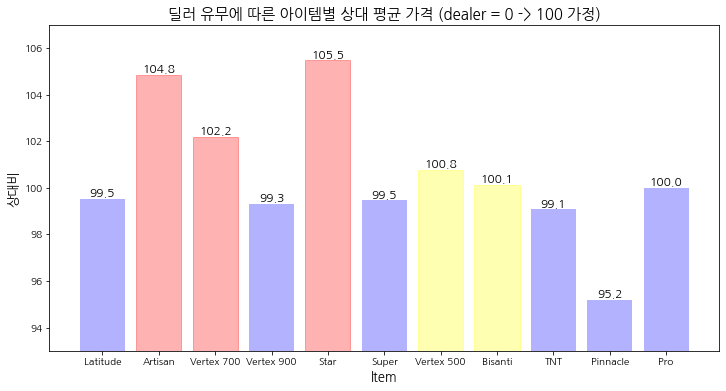

In [ ]:
## 윗 코드 결과 시각화

plt.figure(figsize = (12, 6))
bar = plt.bar(item_ratio['item'], item_ratio.iloc[:, 1], color=['blue'], alpha = 0.3)
for i in range(11):
  if item_ratio.iloc[i, 1] >= 102:
    bar[i].set_color('red')
  elif item_ratio.iloc[i, 1] >= 100:
    bar[i].set_color('yellow')
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2.0, height + 0.06, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.ylim(93, 107)
plt.title('딜러 유무에 따른 아이템별 상대 평균 가격 (dealer = 0 -> 100 가정)', size = 15)
plt.xlabel('Item', size = 13)
plt.ylabel('상대비', size = 13)
plt.show()

In [ ]:
'''## 지역별 딜러 이용 비율을 측정하기 위한 전처리

store = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/store_classification.csv')

total_df_item['by_dealer']= total_df_item['by_dealer'].apply(int)
store_dealer = total_df_item.groupby('store')['by_dealer'].sum().sort_values(ascending = False).to_frame()
store = store.merge(store_dealer, on = 'store', how = 'left')

store['dealer_ratio'] = 100 * store['by_dealer'] / store['works']
store'''

,Unnamed: 0,store,new_store,works,region,by_dealer,dealer_ratio
0,0,21312de55841d2c624d4873b1f13d1f5,서울특별시_0,279,서울특별시,0,0.0
1,1,915456ef4406fd74b592417029179f61,광주광역시_2,30,광주광역시,0,0.0
2,2,971111623cc4c193722c349e4db882a0,인천광역시_6,240,인천광역시,0,0.0
3,3,08281c648c0b30258834699eb531396e,인천광역시_15,172,인천광역시,0,0.0
4,4,804921e22bdbc209960d2df922404741,인천광역시_4,17,인천광역시,0,0.0
...,...,...,...,...,...,...,...
1267,1267,0fb8c308d34d829a80f3202d5414b600,서울특별시_96,1,서울특별시,0,0.0
1268,1268,6e3b9b314b6b004768c0a525d306b36c,인천광역시_61,1,인천광역시,0,0.0
1269,1269,fc5023050ee508bb9fb10dc9a94a3692,경상북도_53,1,경상북도,0,0.0
1270,1270,4ee44ebeea77358eb72bb2cbf6a4e7a7,부산광역시_82,1,부산광역시,0,0.0


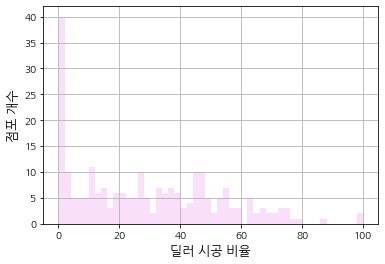

In [ ]:
## 딜러이용 기록이 있는 점포 대상으로 전체 시공 대비 딜러 시공의 비율 시각화

store.loc[store['dealer_ratio'] > 0, 'dealer_ratio'].hist(bins = 50, color = 'violet', alpha = 0.25)
plt.xlabel('딜러 시공 비율', size = 13)
plt.ylabel('점포 개수', size = 13)
plt.show()

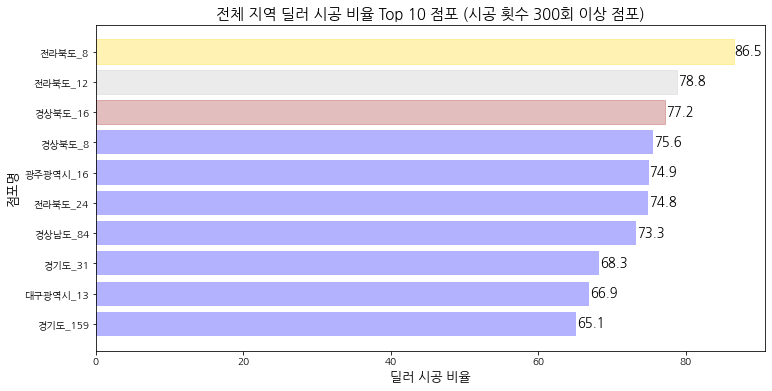

In [ ]:
## top 10 딜러 시공 비율 높은 점포 시각화

top_10_all_region = store.loc[(store['works'] >= 300), ['region', 'new_store', 'dealer_ratio']]\
.sort_values(by = 'dealer_ratio', ascending = False).head(10) # 전체 지역 대상 top 10 딜러 시공 비율 높은 점포 추출 (300회 이상 시공 점포만 대상)

top_10_capital_region = store.loc[(store['works'] >= 300) & (store['region'].isin(['서울특별시', '경기도', '인천광역시'])), ['region', 'new_store', 'dealer_ratio']]\
.sort_values(by = 'dealer_ratio', ascending = False).head(10) # 수도권 지역 대상 top 10 딜러 시공 비율 높은 점포 추출 (300회 이상 시공 점포만 대상)

# 순위대로 보여주기 위해 순서 변경
top_10_all_region = top_10_all_region.iloc[::-1]

# 시각화 코드
plt.figure(figsize = (12, 6))
bar = plt.barh(top_10_all_region.new_store, top_10_all_region.dealer_ratio, color='blue', alpha = 0.3)

# 그래프 옆에 숫자 표시
for rect in bar:
    width = rect.get_width()
    plt.text(width + 2, rect.get_y() + rect.get_height()/4.0, '%.1f' %width, ha='center', va='bottom', size = 13)

# 금은동 색칠
bar[-1].set_color(c = 'gold')
bar[-2].set_color(c = 'silver')
bar[-3].set_color(c = 'brown')

# 제목, 축 이름
plt.title('전체 지역 딜러 시공 비율 Top 10 점포 (시공 횟수 300회 이상 점포)', size = 15)
plt.xlabel('딜러 시공 비율', size = 13)
plt.ylabel('점포명', size = 13)
plt.show()

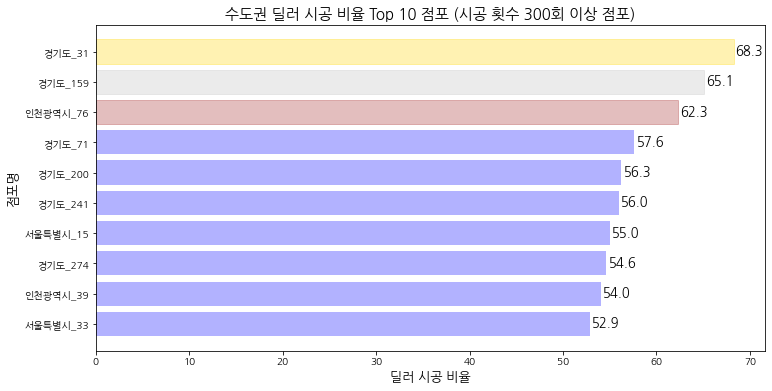

In [ ]:
top_10_capital_region = top_10_capital_region.iloc[::-1]

# 시각화 코드
plt.figure(figsize = (12, 6))
bar = plt.barh(top_10_capital_region.new_store, top_10_capital_region.dealer_ratio, color='blue', alpha = 0.3)

# 그래프 옆에 숫자 표시
for rect in bar:
    width = rect.get_width()
    plt.text(width + 1.7, rect.get_y() + rect.get_height()/4.0, '%.1f' %width, ha='center', va='bottom', size = 13)

# 금은동 색칠
bar[-1].set_color(c = 'gold')
bar[-2].set_color(c = 'silver')
bar[-3].set_color(c = 'brown')

# 제목, 축 이름
plt.title('수도권 딜러 시공 비율 Top 10 점포 (시공 횟수 300회 이상 점포)', size = 15)
plt.xlabel('딜러 시공 비율', size = 13)
plt.ylabel('점포명', size = 13)
plt.show()

In [ ]:
## 지역별 딜러 이용률을 보기위한 전처리

region_works = store.groupby('region')['works'].sum().to_frame()
region_dealer = store.groupby('region')['by_dealer'].sum().to_frame()
region_ratio = region_works.merge(region_dealer, on = 'region')

region_ratio['dealer_ratio'] = 100 * region_ratio['by_dealer'] / region_ratio['works']
region_ratio

,works,by_dealer,dealer_ratio
region,,,
강원도,6701,316,4.715714
경기도,111496,18256,16.373682
경상남도,24184,5913,24.450050
경상북도,20133,5485,27.243829
광주광역시,17679,2624,14.842468
대구광역시,33534,6322,18.852508
대전광역시,16937,2779,16.407864
부산광역시,30331,7539,24.855758
서울특별시,61209,5993,9.791044


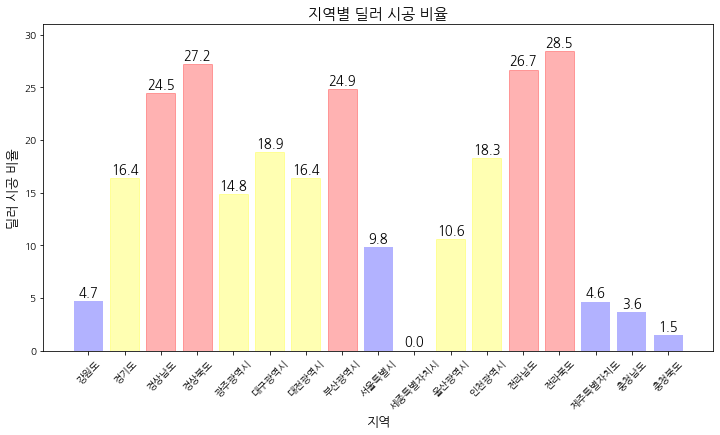

In [ ]:
## 지역별 딜러 이용률 시각화

plt.figure(figsize = (12, 6))
bar = plt.bar(region_ratio.index, region_ratio['dealer_ratio'], color=['blue'], alpha = 0.3)
for i in range(region_ratio.shape[0]):
  if region_ratio.iloc[i, -1] > 20:
    bar[i].set_color('red')
  elif region_ratio.iloc[i, -1] > 10:
    bar[i].set_color('yellow')
for rect in bar:
  height = rect.get_height()
  plt.text(rect.get_x() + rect.get_width()/2.0, height + 0.2, '%.1f' %height, ha='center', va='bottom', size = 13)
plt.title('지역별 딜러 시공 비율', size = 15)
plt.ylim(0, 31)
plt.xticks(rotation = 45)
plt.xlabel('지역', size = 13)
plt.ylabel('딜러 시공 비율', size = 13)
plt.show()

In [ ]:
product_num = pd.DataFrame(pd.Series(list(map(str, [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]))))

ratio = []
for i in range(1, 7):
  ratio.append(100 * no_dealer['product_%d'%i].count() / no_dealer.shape[0])
  ratio.append(100 * yes_dealer['product_%d'%i].count() / yes_dealer.shape[0])

ratio = pd.DataFrame(pd.Series(ratio))

dealer_num = pd.DataFrame(pd.Series(['0', '1'] * 6))

dealer_product = pd.concat([product_num, ratio, dealer_num], axis = 1)
dealer_product.columns = ['product_number', 'purchase_ratio', 'by_dealer']
dealer_product

,product_number,purchase_ratio,by_dealer
0,1,82.239003,0
1,1,92.887797,1
2,2,79.461318,0
3,2,90.815994,1
4,3,8.345094,0
5,3,3.963063,1
6,4,79.819815,0
7,4,92.467517,1
8,5,96.624374,0
9,5,98.623731,1


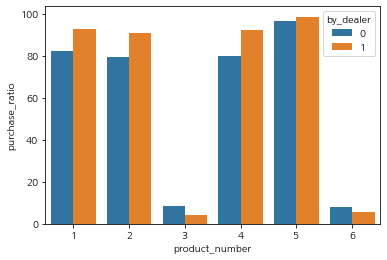

In [ ]:
sns.barplot(y = 'purchase_ratio', x = 'product_number', hue = 'by_dealer', data = dealer_product)
plt.show()